<a href="https://colab.research.google.com/github/birajsth/MachineLearning-with-tensorflow/blob/master/music_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Music Generation with RNN

In [15]:
! git clone https://github.com/aamini/introtodeeplearning_labs.git
% cd introtodeeplearning_labs
! git pull
% cd ..

fatal: destination path 'introtodeeplearning_labs' already exists and is not an empty directory.
/content/introtodeeplearning_labs
Already up to date.
/content


In [0]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
tf.enable_eager_execution()
import functools
from IPython import display as ipythondisplay

#import introtodeeplearning_labs as util

is_eager_enabled = tf.executing_eagerly()
assert is_eager_enabled, "Tensorflow eager mode is not enabled"

assert tf.test.is_gpu_available(), "GPU not available: go to runtime -> change runtime type -> GPU"

!apt-get install abcmidi timidity > /dev/null 2>&1

Dataset of thousands of irish folk songs, represented in the ABC notation .

In [0]:
path_to_file = tf.keras.utils.get_file('irish.abc', 'https://raw.githubusercontent.com/aamini/introtodeeplearning_labs/2019/lab1/data/irish.abc')

In [23]:
text = open(path_to_file).read()
print(f'Length of text: {len(text)}')

Length of text: 197618


In [5]:
print(os.listdir('/content/introtodeeplearning_labs'))

['lab3', '.gitignore', 'README.md', 'lab2', 'lab1', '__pycache__', '.git', '__init__.py']


In [8]:
print(text[:250])

X:1
T:Alexander's
Z: id:dc-hornpipe-1
M:C|
L:1/8
K:D Major
(3ABc|dAFA DFAd|fdcd FAdf|gfge fefd|(3efe (3dcB A2 (3ABc|!
dAFA DFAd|fdcd FAdf|gfge fefd|(3efe dc d2:|!
AG|FAdA FAdA|GBdB GBdB|Acec Acec|dfaf gecA|!
FAdA FAdA|GBdB GBdB|Aceg fefd|(3efe dc d2:


In [24]:
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

83 unique characters


In [0]:
# Creating a mapping from unique characters to indices
char2idx = {u:i for i, u in enumerate(vocab)}
text_as_int = np.array([char2idx[c] for c in text])
idx2char = np.array(vocab)

In [11]:
print(f'{repr(text[:13])} --- characters mapped to int ----> {text_as_int[:13]}')

'X:1\nT:Alexand' --- characters mapped to int ----> [49 22 13  0 45 22 26 67 60 79 56 69 59]


Creating Training example and Targets

In [26]:
# The maximum length sentence we want for a single input in characters.
seq_length = 100
examples_per_epoch = len(text)//seq_length

char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

sequences = char_dataset.batch(seq_length+1, drop_remainder=True)
sequences

<DatasetV1Adapter shapes: (101,), types: tf.int64>

In [0]:
def split_input_target(chunk):
  input_text = chunk[:-1]
  target_text = chunk[1:]
  return input_text, target_text

dataset = sequences.map(split_input_target)

In [28]:
dataset

<DatasetV1Adapter shapes: ((100,), (100,)), types: (tf.int64, tf.int64)>

In [29]:
# creating training batches
BATCH_SIZE = 64
steps_per_epoch = examples_per_epoch//BATCH_SIZE

# Buffer size is similar to a queue size
# This defines a manageable data size to put into memory, where elements are shuffled
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
dataset

<DatasetV1Adapter shapes: ((64, 100), (64, 100)), types: (tf.int64, tf.int64)>

Setting up model

In [0]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 256

# The number of RNN units
rnn_units = 1024


In [0]:
if tf.test.is_gpu_available():
  LSTM = tf.keras.layers.CuDNNLSTM
else:
  LSTM = functools.partial(
    tf.keras.layers.LSTM, recurrent_activation='sigmoid')

LSTM = functools.partial(LSTM, 
                         return_sequences=True,
                         recurrent_initializer='glorot_uniform',
                         stateful=True)

In [0]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
      tf.keras.layers.Embedding(vocab_size, embedding_dim, 
                                batch_input_shape=[batch_size, None]),
      LSTM(rnn_units),
      tf.keras.layers.Dense(vocab_size)
  ])
  return model


In [33]:
model = build_model(
    vocab_size = len(vocab),
    embedding_dim = embedding_dim,
    rnn_units=rnn_units,
    batch_size=BATCH_SIZE)

Instructions for updating:
Colocations handled automatically by placer.


In [34]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, None, 256)           21248     
_________________________________________________________________
cu_dnnlstm (CuDNNLSTM)       (64, None, 1024)          5251072   
_________________________________________________________________
dense (Dense)                (64, None, 83)            85075     
Total params: 5,357,395
Trainable params: 5,357,395
Non-trainable params: 0
_________________________________________________________________


In [37]:
for input_example_batch, target_example_batch in dataset.take(1):
  example_batch_predictions = model(input_example_batch)
  print(example_batch_predictions.shape, "#(batch_size, sequence_length, vocab_size)")

(64, 100, 83) #(batch_size, sequence_length, vocab_size)


Training the model

In [39]:
# loss
def compute_loss(labels, logits):
  return tf.keras.backend.sparse_categorical_crossentropy(labels, logits, from_logits=True)

# computing loss of untrained model
example_batch_loss = compute_loss(target_example_batch, example_batch_predictions)
print('scalar loss: ', example_batch_loss.numpy().mean())

scalar loss:  4.417825


In [0]:
#  Training step
EPOCHS = 5
optimizer = tf.train.AdamOptimizer()
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch}')

history = []
for epoch in range(EPOCHS):
  
  # Initialize the hidden state at the start of every epoch; initially is None
  hidden = model.reset_states()
  
  # Enumerate the dataset for use in training
  for inp, target in dataset:
    # Use tf.GradientTape()
    with tf.GradientTape() as tape:
      predictions = model(inp)
      loss = compute_loss(target, predictions)
      
    # Now, compute the gradients and try to minimize
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    # Update the progress bar!
  history.append(loss.numpy().mean())
  
  model.save_weights(checkpoint_prefix.format(epoch=epoch))

In [55]:
print(len(history))

5


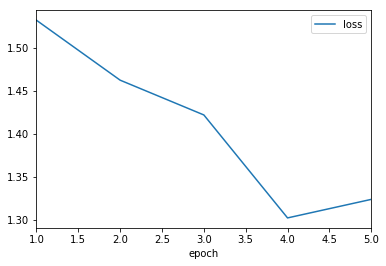

In [66]:
df =pd.DataFrame({'epoch':np.arange(1,EPOCHS+1),'loss':np.array(history)})
df.set_index('epoch',inplace=True)
df.plot.line()